In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

In [2]:
# Set larger default font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

In [3]:
def load_drought_mask(resource, module, domain, variable, simulation, gwl, data_dir="../../data/drought_masks"):
    """
    Load a drought mask from zarr store.
    
    Parameters
    ----------
    resource : str
        Resource type ('pv' or 'windpower')
    module : str
        Module type ('utility', 'distributed', 'onshore', 'offshore')
    domain : str
        Domain ('d02' or 'd03')
    variable : str
        Variable ('cf' or 'gen')
    simulation : str
        Climate model simulation name
    gwl : float
        Global warming level (0.8, 1.5, 2.0, 3.0, etc.)
    data_dir : str or Path
        Directory containing drought mask files
        
    Returns
    -------
    xr.DataArray
        Drought mask (1 = drought, 0 = no drought)
    """
    mask_file = f"{resource}_{module}_{domain}_{variable}_{simulation}_gwl{gwl}_drought_mask_only.zarr"
    mask_path = Path(data_dir) / mask_file
    
    if not mask_path.exists():
        raise FileNotFoundError(f"Drought mask not found: {mask_path}")
    
    # Open zarr store with consolidated metadata
    ds = xr.open_zarr(mask_path, consolidated=True)
    
    return ds['drought_mask']

In [4]:

simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]
domain = 'd02'
target_gwls = [0.8, 2.0]
variable = 'cf'
data_dir = Path("../../data/drought_masks")

In [5]:
def load_and_group_drought_masks(resource,module):
    drought_masks = []
    for target_gwl in target_gwls:
        drought_masks_gwl = []

        for simulation in simulations:

            # Load drought masks for solar and wind
            print(f"Loading drought masks for {simulation} at GWL {target_gwl}°C...")

            drought_mask = load_drought_mask(
                resource=resource,
                module=module,
                domain=domain,
                variable=variable,
                simulation=simulation,
                gwl=target_gwl,
                data_dir=data_dir
            )

            drought_mask['simulation'] = simulation
            drought_mask['target_gwl'] = target_gwl

            drought_masks_gwl.append(drought_mask)
        drought_masks.append(xr.concat(drought_masks_gwl, dim='simulation', join='outer'))
    all_drought_mask = xr.concat(drought_masks, dim='target_gwl', join='outer')
    return all_drought_mask



In [6]:
all_solar_drought_mask = load_and_group_drought_masks('pv','utility')

Loading drought masks for mpi-esm1-2-hr at GWL 0.8°C...
Loading drought masks for miroc6 at GWL 0.8°C...
Loading drought masks for taiesm1 at GWL 0.8°C...
Loading drought masks for ec-earth3 at GWL 0.8°C...
Loading drought masks for mpi-esm1-2-hr at GWL 2.0°C...
Loading drought masks for miroc6 at GWL 2.0°C...
Loading drought masks for taiesm1 at GWL 2.0°C...
Loading drought masks for ec-earth3 at GWL 2.0°C...


In [7]:
all_wind_drought_mask = load_and_group_drought_masks('windpower','onshore')

Loading drought masks for mpi-esm1-2-hr at GWL 0.8°C...
Loading drought masks for miroc6 at GWL 0.8°C...
Loading drought masks for taiesm1 at GWL 0.8°C...
Loading drought masks for ec-earth3 at GWL 0.8°C...
Loading drought masks for mpi-esm1-2-hr at GWL 2.0°C...
Loading drought masks for miroc6 at GWL 2.0°C...
Loading drought masks for taiesm1 at GWL 2.0°C...
Loading drought masks for ec-earth3 at GWL 2.0°C...


In [9]:
def calculate_coincident_metrics(pv_mask, wind_mask):
    """
    Calculate co-occurrence probability between PV and wind droughts at each grid point.
    
    Co-occurrence probability: P(both drought) / [P(PV drought) × P(wind drought)]
    - Values > 1: droughts co-occur more than expected by chance
    - Values < 1: droughts co-occur less than expected (anti-correlated)
    - Values = 1: droughts are independent
    
    Parameters
    ----------
    pv_mask : xr.DataArray
        PV drought mask with dimensions (time, y, x)
    wind_mask : xr.DataArray
        Wind drought mask with dimensions (time, y, x)
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'co_occurrence': Co-occurrence probability (xr.DataArray with dims y, x)
        - 'pv_frequency': PV drought frequency (xr.DataArray)
        - 'wind_frequency': Wind drought frequency (xr.DataArray)
        - 'coincident_frequency': Coincident drought frequency (xr.DataArray)
    """
    # Calculate drought frequencies (probability over time)
    pv_freq = pv_mask.mean(dim='time')
    wind_freq = wind_mask.mean(dim='time')
    
    # Calculate coincident drought (both in drought at same time)
    both_drought = (pv_mask * wind_mask).mean(dim='time')
    
    # Co-occurrence probability: P(both) / [P(PV) × P(wind)]
    # Avoid division by zero
    co_occur = xr.where(
        (pv_freq > 0) & (wind_freq > 0),
        both_drought / (pv_freq * wind_freq),
        np.nan
    )
    
    return {
        'co_occurrence': co_occur,
        'pv_frequency': pv_freq,
        'wind_frequency': wind_freq,
        'coincident_frequency': both_drought
    }


def calculate_metrics_for_all(pv_masks, wind_masks, simulations, gwls):
    """
    Calculate coincident drought metrics for all simulations and GWLs.
    
    Parameters
    ----------
    pv_masks : xr.DataArray
        PV drought masks with dims (target_gwl, simulation, time, y, x)
    wind_masks : xr.DataArray
        Wind drought masks with dims (target_gwl, simulation, time, y, x)
    simulations : list
        List of simulation names
    gwls : list
        List of GWL values
        
    Returns
    -------
    dict
        Nested dictionary: results[gwl][simulation] = metrics_dict
    """
    results = {}
    
    for gwl in gwls:
        results[gwl] = {}
        print(f"\n{'='*60}")
        print(f"Processing GWL {gwl}°C")
        print(f"{'='*60}")
        
        for sim in simulations:
            print(f"\nCalculating metrics for {sim}...")
            
            # Select data for this GWL and simulation
            pv_mask = pv_masks.sel(target_gwl=gwl, simulation=sim)
            wind_mask = wind_masks.sel(target_gwl=gwl, simulation=sim)
            
            # Calculate metrics
            metrics = calculate_coincident_metrics(pv_mask, wind_mask)
            
            # Calculate summary statistics
            co_occur_mean = float(metrics['co_occurrence'].mean(skipna=True).values)
            pv_freq_mean = float(metrics['pv_frequency'].mean(skipna=True).values)
            wind_freq_mean = float(metrics['wind_frequency'].mean(skipna=True).values)
            coincident_mean = float(metrics['coincident_frequency'].mean(skipna=True).values)
            
            print(f"  PV drought frequency: {pv_freq_mean:.3f}")
            print(f"  Wind drought frequency: {wind_freq_mean:.3f}")
            print(f"  Coincident frequency: {coincident_mean:.3f}")
            print(f"  Co-occurrence probability: {co_occur_mean:.3f}")
            
            results[gwl][sim] = metrics
    
    return results

In [10]:
# Calculate metrics for all simulations and GWLs
coincident_results = calculate_metrics_for_all(
    all_solar_drought_mask, 
    all_wind_drought_mask, 
    simulations, 
    target_gwls
)


# Print summary
print("\n" + "="*70)
print("Summary: Mean Coincident events per year by GWL and Simulation")
print("="*70)
print(f"{'Simulation':<20s} {'GWL 0.8°C':>12s} {'GWL 2.0°C':>12s} {'Change':>12s}")
print("-" * 70)

for sim in simulations:
    co_occur_08 = float(coincident_results[0.8][sim]['coincident_frequency'].mean(skipna=True).values)*365
    co_occur_20 = float(coincident_results[2.0][sim]['coincident_frequency'].mean(skipna=True).values)*365
    change = co_occur_20 - co_occur_08
    print(f"{sim:<20s} {co_occur_08:>12.3f} {co_occur_20:>12.3f} {change:>+12.3f}")


# Print summary
print("\n" + "="*70)
print("Summary: Mean Co-occurrence Probability by GWL and Simulation")
print("="*70)
print(f"{'Simulation':<20s} {'GWL 0.8°C':>12s} {'GWL 2.0°C':>12s} {'Change':>12s}")
print("-" * 70)

for sim in simulations:
    co_occur_08 = float(coincident_results[0.8][sim]['co_occurrence'].mean(skipna=True).values)
    co_occur_20 = float(coincident_results[2.0][sim]['co_occurrence'].mean(skipna=True).values)
    change = co_occur_20 - co_occur_08
    print(f"{sim:<20s} {co_occur_08:>12.3f} {co_occur_20:>12.3f} {change:>+12.3f}")




Processing GWL 0.8°C

Calculating metrics for mpi-esm1-2-hr...
  PV drought frequency: 0.052
  Wind drought frequency: 0.054
  Coincident frequency: 0.006
  Co-occurrence probability: 1.183

Calculating metrics for miroc6...
  PV drought frequency: 0.050
  Wind drought frequency: 0.052
  Coincident frequency: 0.006
  Co-occurrence probability: 1.355

Calculating metrics for taiesm1...
  PV drought frequency: 0.051
  Wind drought frequency: 0.052
  Coincident frequency: 0.006
  Co-occurrence probability: 1.317

Calculating metrics for ec-earth3...
  PV drought frequency: 0.051
  Wind drought frequency: 0.052
  Coincident frequency: 0.006
  Co-occurrence probability: 1.241

Processing GWL 2.0°C

Calculating metrics for mpi-esm1-2-hr...
  PV drought frequency: 0.055
  Wind drought frequency: 0.057
  Coincident frequency: 0.007
  Co-occurrence probability: 1.207

Calculating metrics for miroc6...
  PV drought frequency: 0.052
  Wind drought frequency: 0.055
  Coincident frequency: 0.007
 

In [11]:
# Load all coincident results into memory for fast plotting
print("Loading data into memory...")
print("This may take a minute, but will make all subsequent plots much faster.\n")

for gwl in target_gwls:
    print(f"Loading GWL {gwl}°C data...")
    for sim in simulations:
        print(f"  {sim}...", end=" ")
        
        # Load each metric array into memory
        coincident_results[gwl][sim]['co_occurrence'] = coincident_results[gwl][sim]['co_occurrence'].compute()
        coincident_results[gwl][sim]['pv_frequency'] = coincident_results[gwl][sim]['pv_frequency'].compute()
        coincident_results[gwl][sim]['wind_frequency'] = coincident_results[gwl][sim]['wind_frequency'].compute()
        coincident_results[gwl][sim]['coincident_frequency'] = coincident_results[gwl][sim]['coincident_frequency'].compute()
        
        print("✓")

print("\nData loaded! All plots will now be fast.")

Loading data into memory...
This may take a minute, but will make all subsequent plots much faster.

Loading GWL 0.8°C data...
  mpi-esm1-2-hr... ✓
  miroc6... ✓
  taiesm1... ✓
  ec-earth3... ✓
Loading GWL 2.0°C data...
  mpi-esm1-2-hr... ✓
  miroc6... ✓
  taiesm1... ✓
  ec-earth3... ✓

Data loaded! All plots will now be fast.


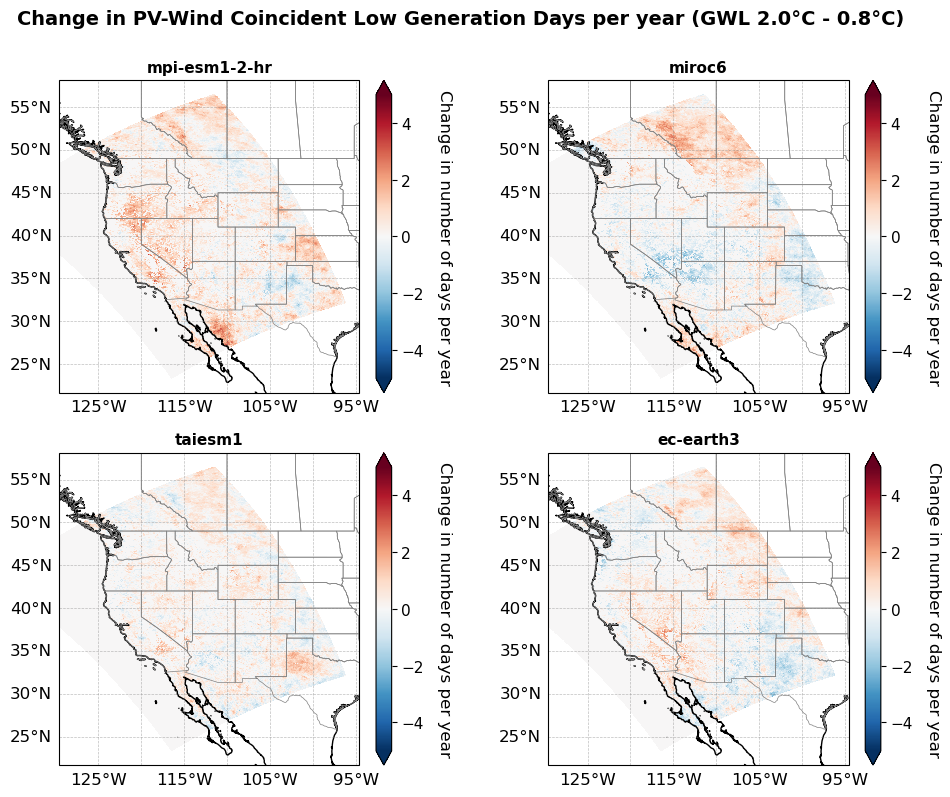

In [31]:
# Calculate and visualize CHANGES between GWL 0.8 and 2.0
fig, axes = plt.subplots(2, 2, figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, sim in enumerate(simulations):
    # Calculate change in coincident frequency
    freq_08 = coincident_results[0.8][sim]['coincident_frequency']*365 # number of occurences per year
    freq_20 = coincident_results[2.0][sim]['coincident_frequency']* 365
    
    # Absolute change
    change = freq_20 - freq_08
    
    # Set extent
    lon_min, lon_max = float(change.lon.min()), float(change.lon.max())
    lat_min, lat_max = float(change.lat.min()), float(change.lat.max())
    lon_min = -128
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot change with diverging colormap
    im = change.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='RdBu_r',
        vmin=-5,
        vmax=5,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, extend='both')
    cbar.set_label('Change in number of days per year', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean change and percent change
    mean_change = float(change.mean(skipna=True).values)
    mean_08 = float(freq_08.mean(skipna=True).values)
    pct_change = (mean_change / mean_08 * 100) if mean_08 > 0 else 0
    
    axes[i].set_title(f'{sim}', 
                      fontsize=11, fontweight='bold')

plt.suptitle('Change in PV-Wind Coincident Low Generation Days per year (GWL 2.0°C - 0.8°C)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Ensemble (Multi-Model Mean) Maps

Calculate and visualize ensemble metrics by averaging across all climate models.

In [32]:
# Calculate ensemble (multi-model mean) for each GWL
ensemble_results = {}

for gwl in target_gwls:
    print(f"Calculating ensemble for GWL {gwl}°C...")
    
    # Stack co-occurrence and Jaccard across models
    co_occur_stack = xr.concat([coincident_results[gwl][sim]['co_occurrence'] for sim in simulations], dim='model')
    
    # Calculate mean across models
    ensemble_co_occur = co_occur_stack.mean(dim='model', skipna=True)
    
    ensemble_results[gwl] = {
        'co_occurrence': ensemble_co_occur,
        'co_occur_std': co_occur_stack.std(dim='model', skipna=True),
    }
    
    print(f"  Mean co-occurrence: {float(ensemble_co_occur.mean(skipna=True).values):.3f}")
    print(f"  Co-occurrence std: {float(ensemble_results[gwl]['co_occur_std'].mean(skipna=True).values):.3f}")


Calculating ensemble for GWL 0.8°C...
  Mean co-occurrence: 1.274
  Co-occurrence std: 0.124
Calculating ensemble for GWL 2.0°C...
  Mean co-occurrence: 1.250
  Co-occurrence std: 0.105


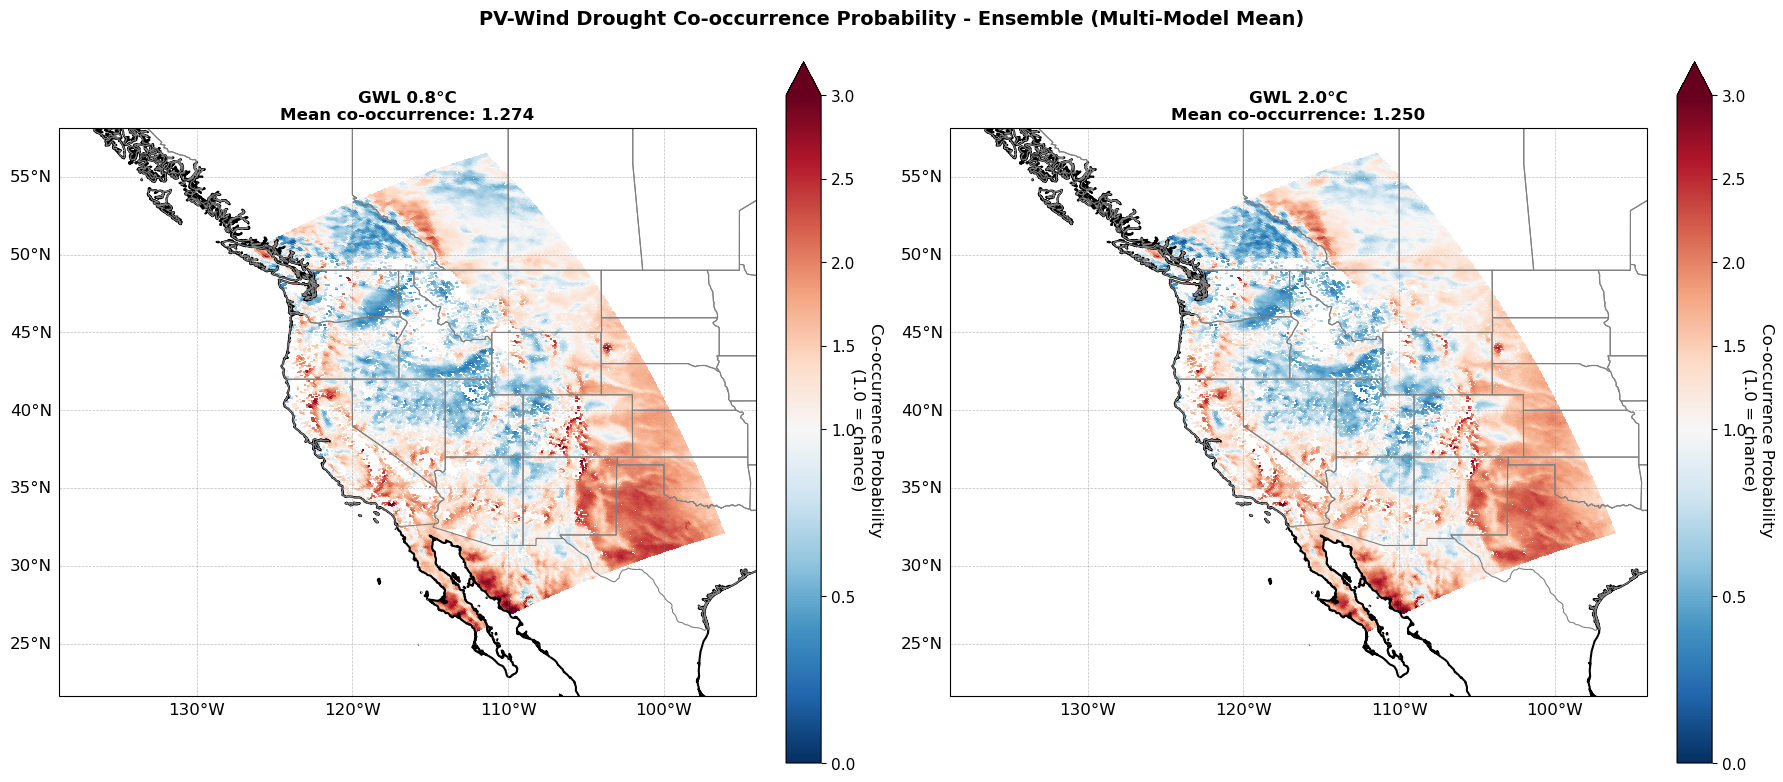

In [33]:
# Visualize ensemble co-occurrence for both GWLs side by side
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection': ccrs.PlateCarree()})

for i, gwl in enumerate(target_gwls):
    co_occur = ensemble_results[gwl]['co_occurrence']
    
    # Set extent
    lon_min, lon_max = float(co_occur.lon.min()), float(co_occur.lon.max())
    lat_min, lat_max = float(co_occur.lat.min()), float(co_occur.lat.max())
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot co-occurrence with colormap centered at 1.0 (chance level)
    norm = TwoSlopeNorm(vmin=0, vcenter=1.0, vmax=3.0)
    
    im = co_occur.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='RdBu_r',
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, extend='max')
    cbar.set_label('Co-occurrence Probability\n(1.0 = chance)', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1.5, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.8, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean for title
    mean_val = float(co_occur.mean(skipna=True).values)
    axes[i].set_title(f'GWL {gwl}°C\nMean co-occurrence: {mean_val:.3f}', 
                      fontsize=12, fontweight='bold')

plt.suptitle('PV-Wind Drought Co-occurrence Probability - Ensemble (Multi-Model Mean)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

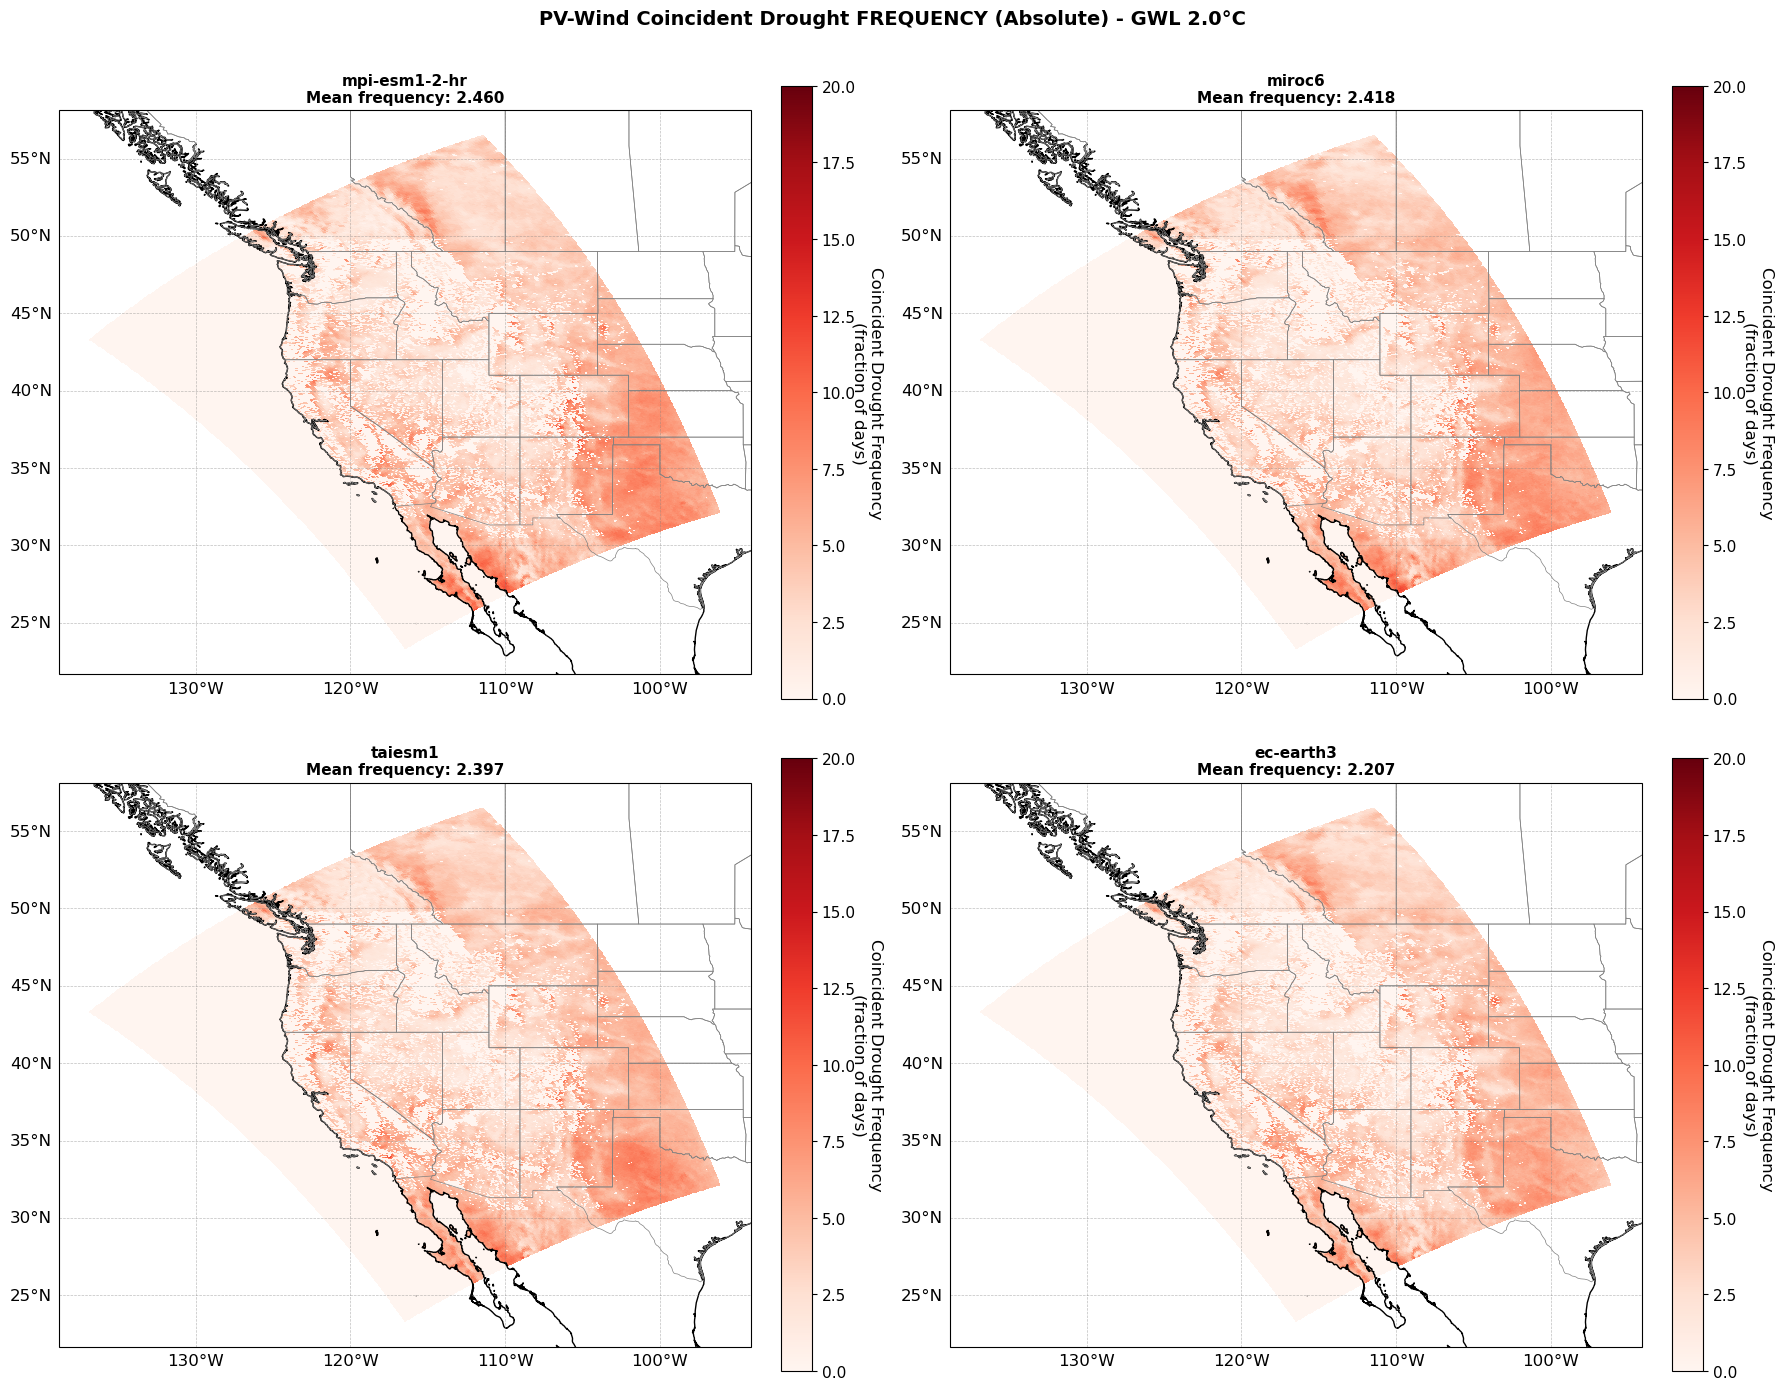

In [34]:
# Visualize coincident drought FREQUENCY for GWL 2.0°C
fig, axes = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

gwl = 2.0

for i, sim in enumerate(simulations):
    freq = coincident_results[gwl][sim]['coincident_frequency']*365
    
    # Set extent
    lon_min, lon_max = float(freq.lon.min()), float(freq.lon.max())
    lat_min, lat_max = float(freq.lat.min()), float(freq.lat.max())
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot absolute frequency
    im = freq.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='Reds',
        vmin=0,
        vmax=20,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Coincident Drought Frequency\n(fraction of days)', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean for title
    mean_val = float(freq.mean(skipna=True).values)
    axes[i].set_title(f'{sim}\nMean frequency: {mean_val:.3f}', 
                      fontsize=11, fontweight='bold')

plt.suptitle(f'PV-Wind Coincident Drought FREQUENCY (Absolute) - GWL {gwl}°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

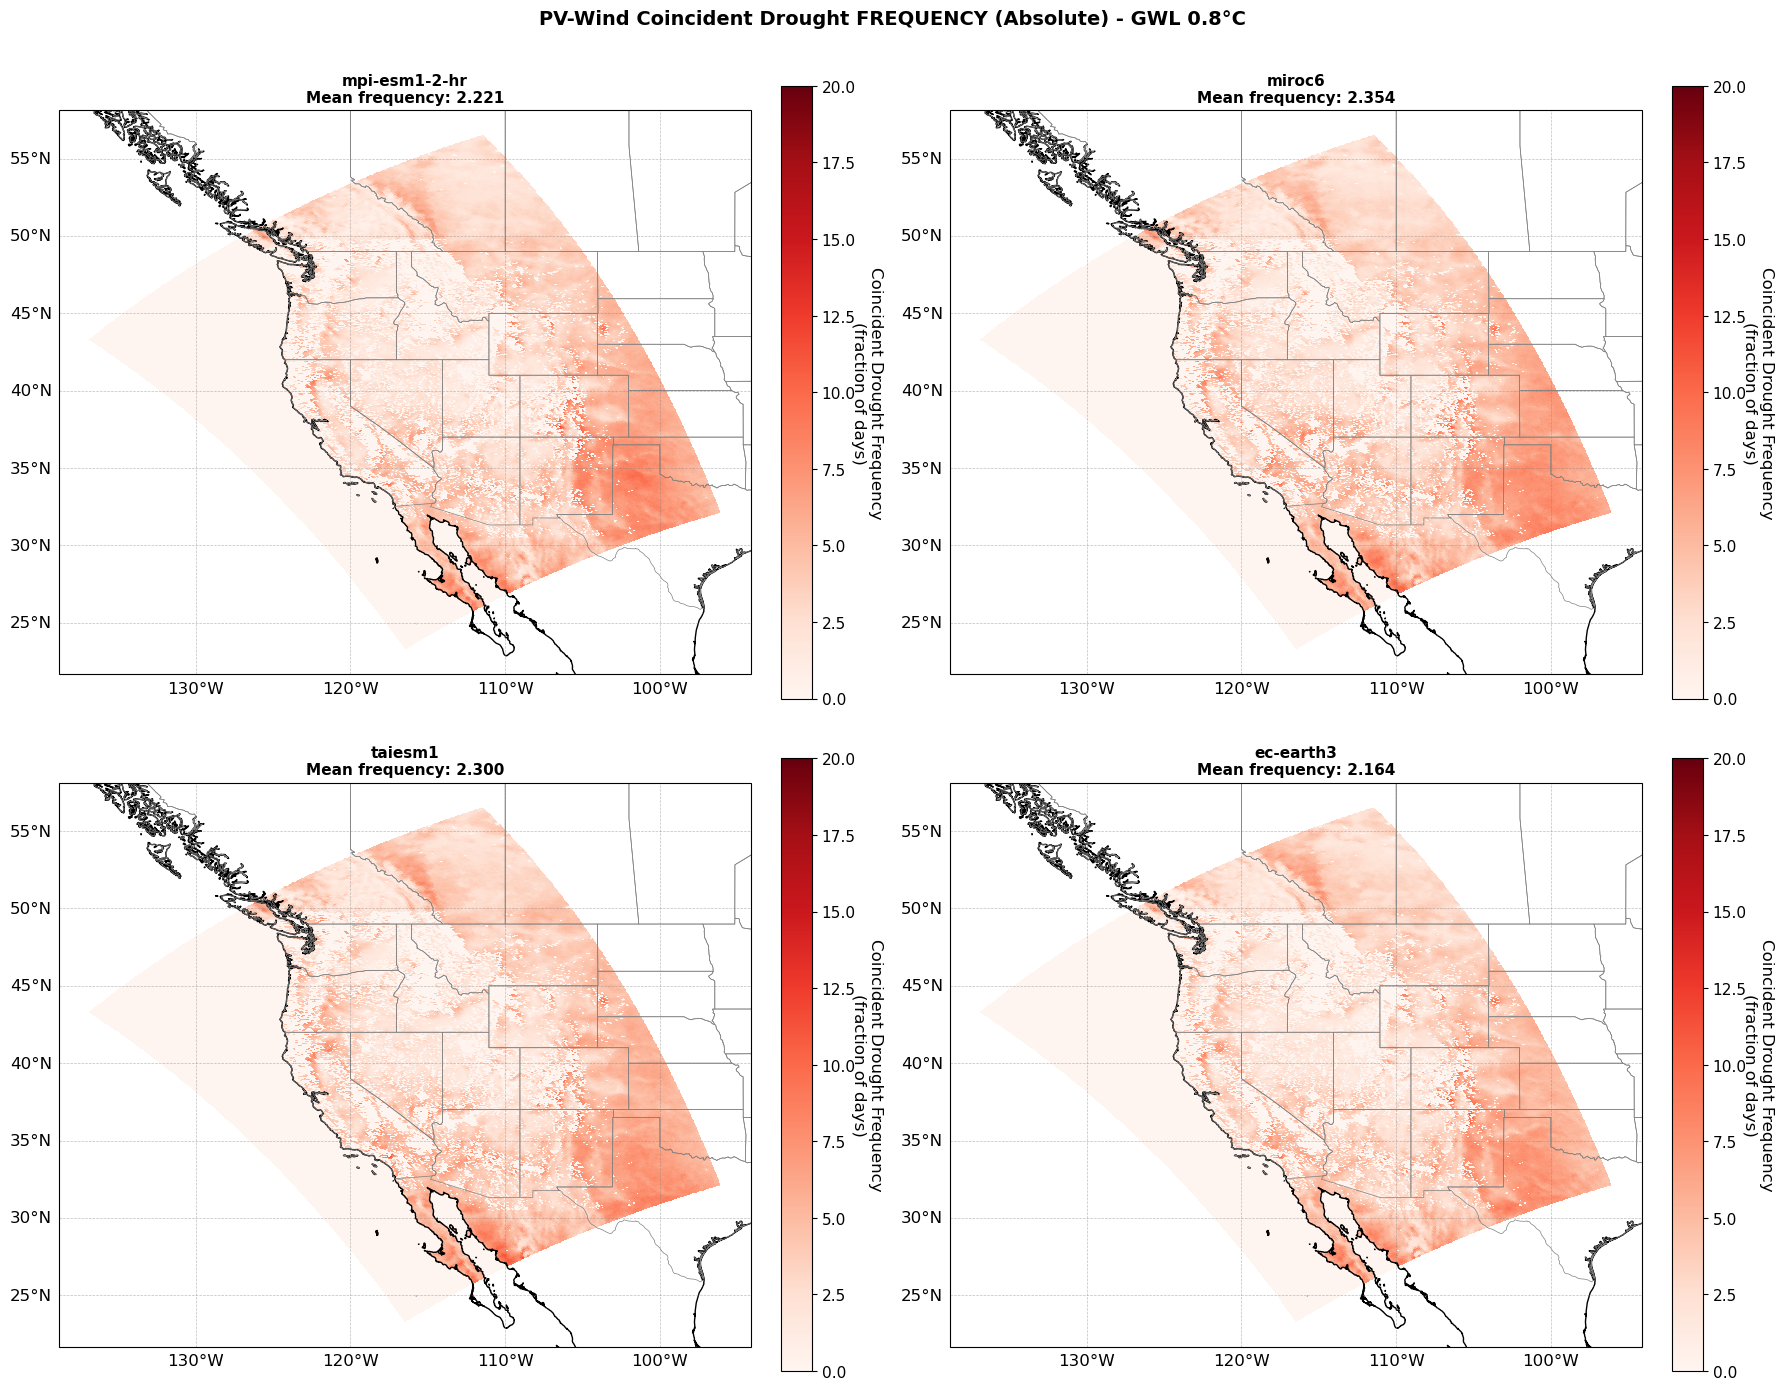

In [ ]:
# Visualize coincident drought FREQUENCY for GWL 0.8°C
fig, axes = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

gwl = 0.8

for i, sim in enumerate(simulations):
    freq = coincident_results[gwl][sim]['coincident_frequency']*365
    
    # Set extent
    lon_min, lon_max = float(freq.lon.min()), float(freq.lon.max())
    lat_min, lat_max = float(freq.lat.min()), float(freq.lat.max())
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot absolute frequency
    im = freq.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='Reds',
        vmin=0,
        vmax=20,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    cbar.set_label('Coincident Drought Frequency\n(fraction of days)', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean for title
    mean_val = float(freq.mean(skipna=True).values)
    axes[i].set_title(f'{sim}\nMean frequency: {mean_val:.3f}', 
                      fontsize=11, fontweight='bold')

plt.suptitle(f'PV-Wind Coincident Drought FREQUENCY (Absolute) - GWL {gwl}°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Visualize Absolute Frequencies


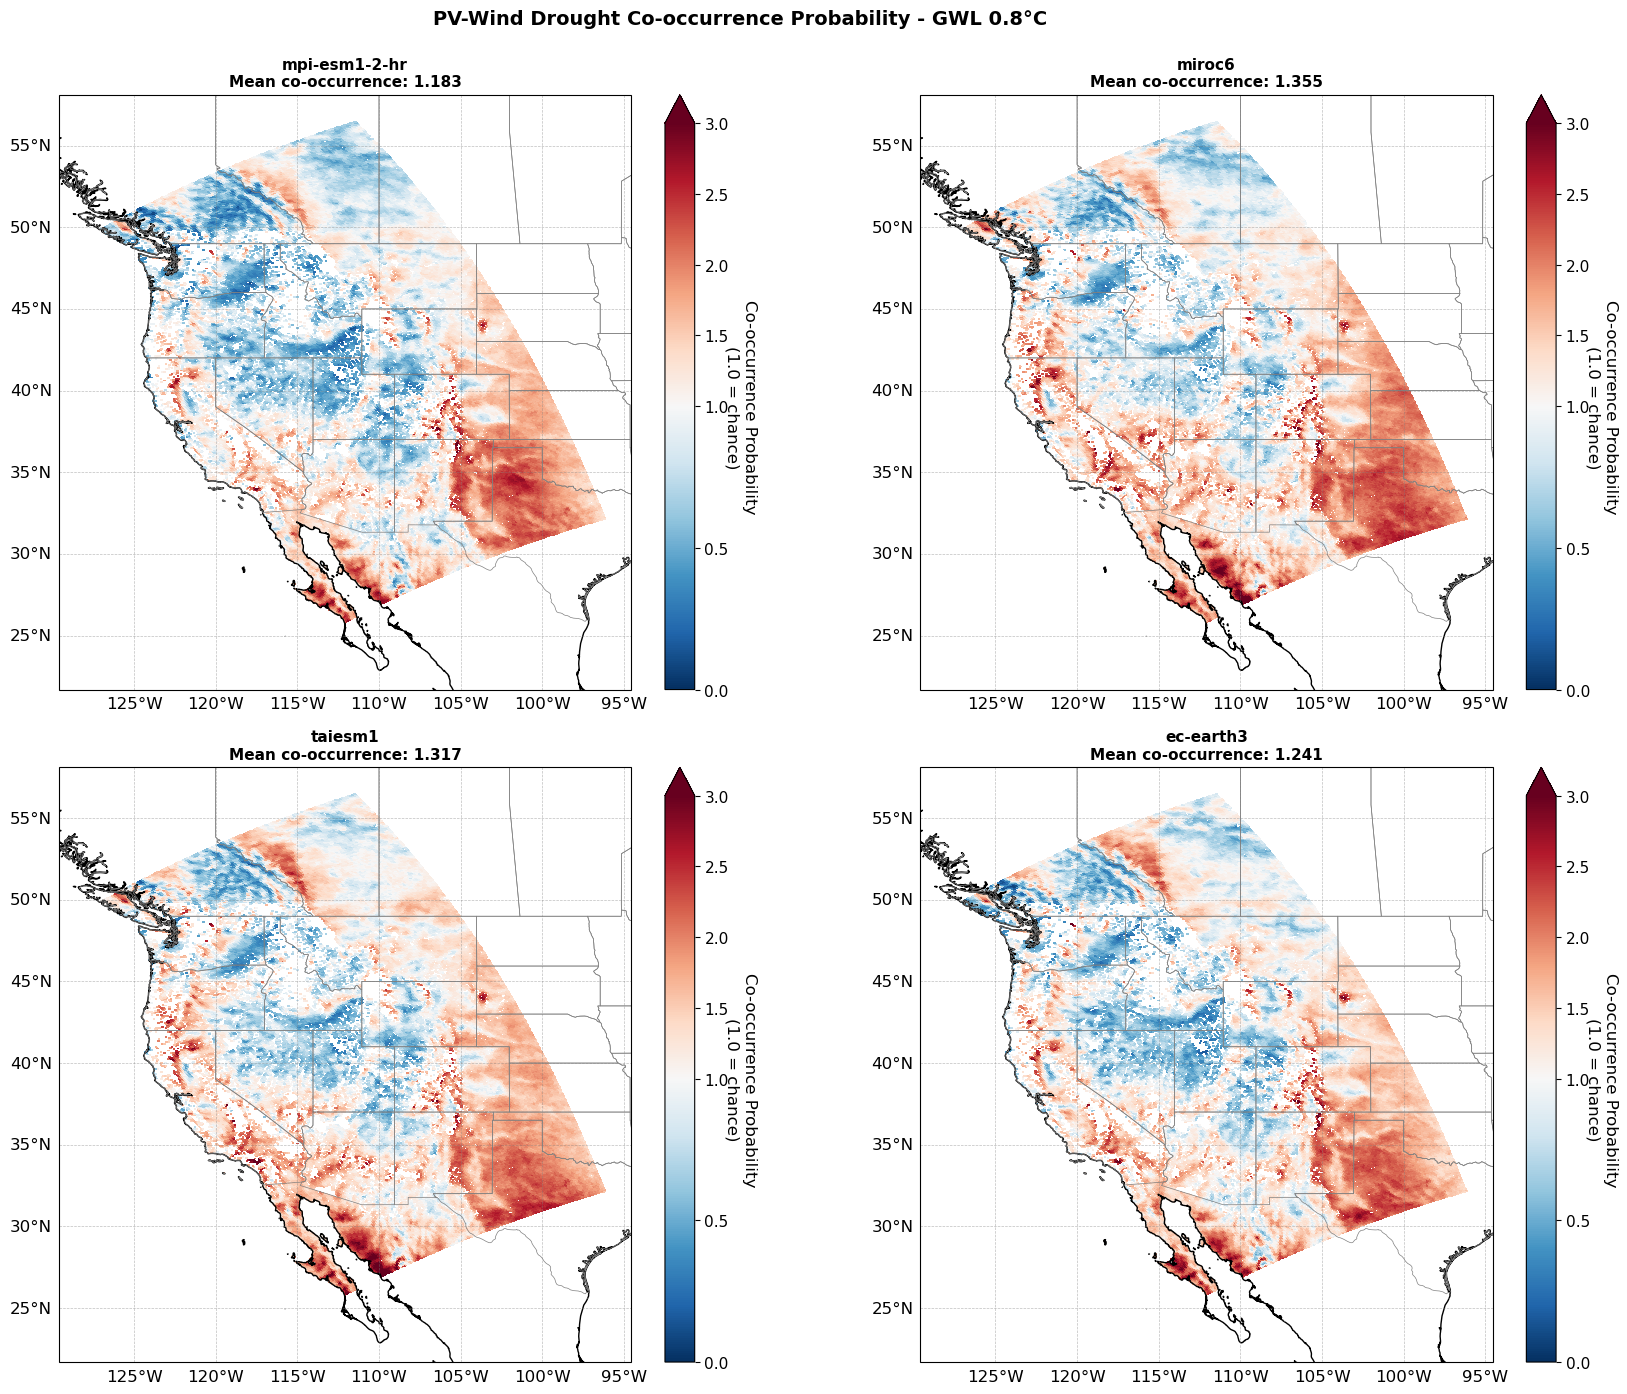

In [35]:
# Visualize co-occurrence probability for GWL 0.8°C
from matplotlib.colors import TwoSlopeNorm

fig, axes = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

gwl = 0.8

for i, sim in enumerate(simulations):
    co_occur = coincident_results[gwl][sim]['co_occurrence']
    
    # Set extent
    lon_min, lon_max = float(co_occur.lon.min()), float(co_occur.lon.max())
    lat_min, lat_max = float(co_occur.lat.min()), float(co_occur.lat.max())
    lon_min = -128
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot co-occurrence with colormap centered at 1.0 (chance level)
    norm = TwoSlopeNorm(vmin=0, vcenter=1.0, vmax=3.0)
    
    im = co_occur.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='RdBu_r',
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, extend='max')
    cbar.set_label('Co-occurrence Probability\n(1.0 = chance)', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean for title
    mean_val = float(co_occur.mean(skipna=True).values)
    axes[i].set_title(f'{sim}\nMean co-occurrence: {mean_val:.3f}', 
                      fontsize=11, fontweight='bold')

plt.suptitle(f'PV-Wind Drought Co-occurrence Probability - GWL {gwl}°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

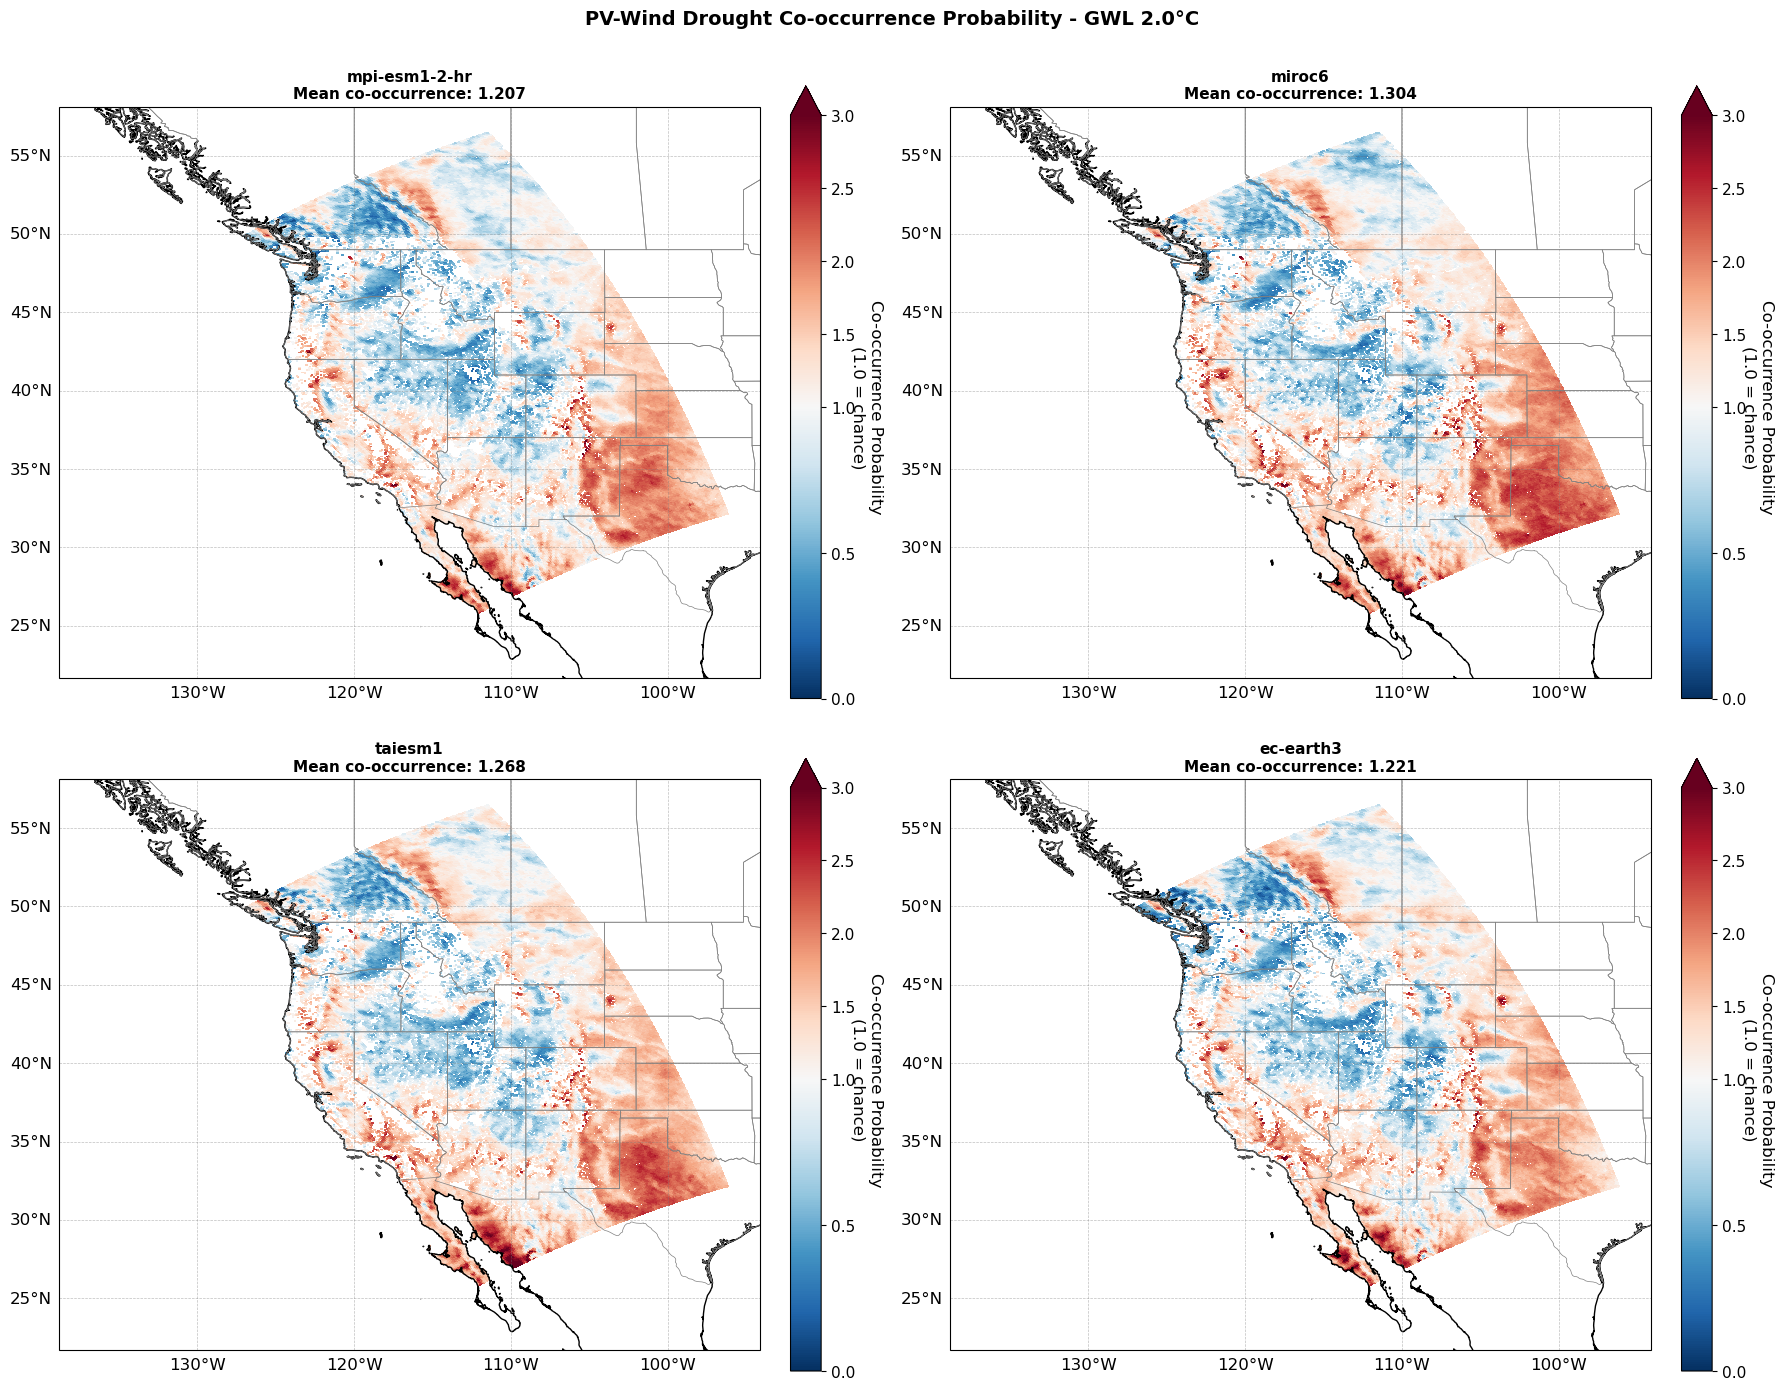

In [36]:
# Visualize co-occurrence probability for GWL 2.0°C
fig, axes = plt.subplots(2, 2, figsize=(18, 14), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

gwl = 2.0

for i, sim in enumerate(simulations):
    co_occur = coincident_results[gwl][sim]['co_occurrence']
    
    # Set extent
    lon_min, lon_max = float(co_occur.lon.min()), float(co_occur.lon.max())
    lat_min, lat_max = float(co_occur.lat.min()), float(co_occur.lat.max())
    lon_pad = (lon_max - lon_min) * 0.05
    lat_pad = (lat_max - lat_min) * 0.05
    extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]
    axes[i].set_extent(extent, crs=ccrs.PlateCarree())
    
    # Plot co-occurrence with colormap centered at 1.0 (chance level)
    norm = TwoSlopeNorm(vmin=0, vcenter=1.0, vmax=3.0)
    
    im = co_occur.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='RdBu_r',
        norm=norm,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, extend='max')
    cbar.set_label('Co-occurrence Probability\n(1.0 = chance)', rotation=270, labelpad=20)
    
    # Add geographic features
    axes[i].coastlines(resolution='10m', linewidth=1, color='black')
    axes[i].add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', facecolor='none')
    
    # Add gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Calculate mean for title
    mean_val = float(co_occur.mean(skipna=True).values)
    axes[i].set_title(f'{sim}\nMean co-occurrence: {mean_val:.3f}', 
                      fontsize=11, fontweight='bold')

plt.suptitle(f'PV-Wind Drought Co-occurrence Probability - GWL {gwl}°C', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()